In [1]:
!pip install -q git+https://github.com/tensorflow/docs

# Imports

In [2]:
import tensorflow as tf
import tensorflow_hub as hub
from tensorflow_docs.vis import embed
import numpy as np
import pandas as pd
import cv2
import os
# Import matplotlib libraries
from matplotlib import pyplot as plt
from matplotlib.collections import LineCollection
import matplotlib.patches as patches

# Some modules to display an animation using imageio.
import imageio
from IPython.display import HTML, display



2024-02-20 06:27:21.496445: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-02-20 06:27:21.496586: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-02-20 06:27:21.657560: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


# Deploying pretrained Movenet Model

In [3]:
model_name = "movenet_lightning"

if "tflite" in model_name:
  if "movenet_lightning_f16" in model_name:
    !wget -q -O model.tflite https://tfhub.dev/google/lite-model/movenet/singlepose/lightning/tflite/float16/4?lite-format=tflite
    input_size = 192
  elif "movenet_thunder_f16" in model_name:
    !wget -q -O model.tflite https://tfhub.dev/google/lite-model/movenet/singlepose/thunder/tflite/float16/4?lite-format=tflite
    input_size = 256
  elif "movenet_lightning_int8" in model_name:
    !wget -q -O model.tflite https://tfhub.dev/google/lite-model/movenet/singlepose/lightning/tflite/int8/4?lite-format=tflite
    input_size = 192
  elif "movenet_thunder_int8" in model_name:
    !wget -q -O model.tflite https://tfhub.dev/google/lite-model/movenet/singlepose/thunder/tflite/int8/4?lite-format=tflite
    input_size = 256
  else:
    raise ValueError("Unsupported model name: %s" % model_name)

  # Initialize the TFLite interpreter
  interpreter = tf.lite.Interpreter(model_path="model.tflite")
  interpreter.allocate_tensors()

  def movenet(input_image):
    """Runs detection on an input image.

    Args:
      input_image: A [1, height, width, 3] tensor represents the input image
        pixels. Note that the height/width should already be resized and match the
        expected input resolution of the model before passing into this function.

    Returns:
      A [1, 1, 17, 3] float numpy array representing the predicted keypoint
      coordinates and scores.
    """
    # TF Lite format expects tensor type of uint8.
    input_image = tf.cast(input_image, dtype=tf.uint8)
    input_details = interpreter.get_input_details()
    output_details = interpreter.get_output_details()
    interpreter.set_tensor(input_details[0]['index'], input_image.numpy())
    # Invoke inference.
    interpreter.invoke()
    # Get the model prediction.
    keypoints_with_scores = interpreter.get_tensor(output_details[0]['index'])
    return keypoints_with_scores

else:
  if "movenet_lightning" in model_name:
    module = hub.load("https://tfhub.dev/google/movenet/singlepose/lightning/4")
    input_size = 192
  elif "movenet_thunder" in model_name:
    module = hub.load("https://tfhub.dev/google/movenet/singlepose/thunder/4")
    input_size = 256
  else:
    raise ValueError("Unsupported model name: %s" % model_name)

  def movenet(input_image):
    """Runs detection on an input image.

    Args:
      input_image: A [1, height, width, 3] tensor represents the input image
        pixels. Note that the height/width should already be resized and match the
        expected input resolution of the model before passing into this function.

    Returns:
      A [1, 1, 17, 3] float numpy array representing the predicted keypoint
      coordinates and scores.
    """
    model = module.signatures['serving_default']

    # SavedModel format expects tensor type of int32.
    input_image = tf.cast(input_image, dtype=tf.int32)
    # Run model inference.
    outputs = model(input_image)
    # Output is a [1, 1, 17, 3] tensor.
    keypoints_with_scores = outputs['output_0'].numpy()
    return keypoints_with_scores

# Loading Training Images 

In [4]:

# Path to the folder containing images
folder_path = '/kaggle/input/mpii-human-pose/mpii_human_pose_v1/images'

# List all files in the folder
image_files = os.listdir(folder_path)

# Iterate over each image file
for file_name in image_files[:10]:
    # Construct the full path to the image file
    image_path = os.path.join(folder_path, file_name) 
    # Read and decode the image
    image = tf.io.read_file(image_path)
    image = tf.image.decode_jpeg(image)
    

# Mappings 

In [14]:
# Dictionary that maps from joint names to keypoint indices.
KEYPOINT_DICT = {
    'nose': 0,
    'left_eye': 1,
    'right_eye': 2,
    'left_ear': 3,
    'right_ear': 4,
    'left_shoulder': 5,
    'right_shoulder': 6,
    'left_elbow': 7,
    'right_elbow': 8,
    'left_wrist': 9,
    'right_wrist': 10,
    'left_hip': 11,
    'right_hip': 12,
    'left_knee': 13,
    'right_knee': 14,
    'left_ankle': 15,
    'right_ankle': 16
}

# Maps bones to a matplotlib color name.
KEYPOINT_EDGE_INDS_TO_COLOR = {
    (0, 1): 'm',
    (0, 2): 'c',
    (1, 3): 'm',
    (2, 4): 'c',
    (0, 5): 'm',
    (0, 6): 'c',
    (5, 7): 'm',
    (7, 9): 'm',
    (6, 8): 'c',
    (8, 10): 'c',
    (5, 6): 'y',
    (5, 11): 'm',
    (6, 12): 'c',
    (11, 12): 'y',
    (11, 13): 'm',
    (13, 15): 'm',
    (12, 14): 'c',
    (14, 16): 'c'
}

def _keypoints_and_edges_for_display(keypoints_with_scores,
                                     height,
                                     width,
                                     keypoint_threshold=0.11):
  """Returns high confidence keypoints and edges for visualization.

  Args:
    keypoints_with_scores: A numpy array with shape [1, 1, 17, 3] representing
      the keypoint coordinates and scores returned from the MoveNet model.
    height: height of the image in pixels.
    width: width of the image in pixels.
    keypoint_threshold: minimum confidence score for a keypoint to be
      visualized.

  Returns:
    A (keypoints_xy, edges_xy, edge_colors) containing:
      * the coordinates of all keypoints of all detected entities;
      * the coordinates of all skeleton edges of all detected entities;
      * the colors in which the edges should be plotted.
  """
  keypoints_all = []
  keypoint_edges_all = []
  edge_colors = []
  num_instances, _, _, _ = keypoints_with_scores.shape
  for idx in range(num_instances):
    kpts_x = keypoints_with_scores[0, idx, :, 1]
    kpts_y = keypoints_with_scores[0, idx, :, 0]
    kpts_scores = keypoints_with_scores[0, idx, :, 2]
    kpts_absolute_xy = np.stack(
        [width * np.array(kpts_x), height * np.array(kpts_y)], axis=-1)
    kpts_above_thresh_absolute = kpts_absolute_xy[
        kpts_scores > keypoint_threshold, :]
    keypoints_all.append(kpts_above_thresh_absolute)

    for edge_pair, color in KEYPOINT_EDGE_INDS_TO_COLOR.items():
      if (kpts_scores[edge_pair[0]] > keypoint_threshold and
          kpts_scores[edge_pair[1]] > keypoint_threshold):
        x_start = kpts_absolute_xy[edge_pair[0], 0]
        y_start = kpts_absolute_xy[edge_pair[0], 1]
        x_end = kpts_absolute_xy[edge_pair[1], 0]
        y_end = kpts_absolute_xy[edge_pair[1], 1]
        line_seg = np.array([[x_start, y_start], [x_end, y_end]])
        keypoint_edges_all.append(line_seg)
        edge_colors.append(color)
  if keypoints_all:
    keypoints_xy = np.concatenate(keypoints_all, axis=0)
  else:
    keypoints_xy = np.zeros((0, 17, 2))

  if keypoint_edges_all:
    edges_xy = np.stack(keypoint_edges_all, axis=0)
  else:
    edges_xy = np.zeros((0, 2, 2))
  return keypoints_xy, edges_xy, edge_colors


def draw_prediction_on_image(
    image, keypoints_with_scores, crop_region=None, close_figure=False,
    output_image_height=None):
  """Draws the keypoint predictions on image.

  Args:
    image: A numpy array with shape [height, width, channel] representing the
      pixel values of the input image.
    keypoints_with_scores: A numpy array with shape [1, 1, 17, 3] representing
      the keypoint coordinates and scores returned from the MoveNet model.
    crop_region: A dictionary that defines the coordinates of the bounding box
      of the crop region in normalized coordinates (see the init_crop_region
      function below for more detail). If provided, this function will also
      draw the bounding box on the image.
    output_image_height: An integer indicating the height of the output image.
      Note that the image aspect ratio will be the same as the input image.

  Returns:
    A numpy array with shape [out_height, out_width, channel] representing the
    image overlaid with keypoint predictions.
  """
  height, width, channel = image.shape
  aspect_ratio = float(width) / height
  fig, ax = plt.subplots(figsize=(12 * aspect_ratio, 12))
  # To remove the huge white borders
  fig.tight_layout(pad=0)
  ax.margins(0)
  ax.set_yticklabels([])
  ax.set_xticklabels([])
  plt.axis('off')

  im = ax.imshow(image)
  line_segments = LineCollection([], linewidths=(4), linestyle='solid')
  ax.add_collection(line_segments)
  # Turn off tick labels
  scat = ax.scatter([], [], s=60, color='#FF1493', zorder=3)

  (keypoint_locs, keypoint_edges,
   edge_colors) = _keypoints_and_edges_for_display(
       keypoints_with_scores, height, width)

  line_segments.set_segments(keypoint_edges)
  line_segments.set_color(edge_colors)
  if keypoint_edges.shape[0]:
    line_segments.set_segments(keypoint_edges)
    line_segments.set_color(edge_colors)
  if keypoint_locs.shape[0]:
    scat.set_offsets(keypoint_locs)

  if crop_region is not None:
    xmin = max(crop_region['x_min'] * width, 0.0)
    ymin = max(crop_region['y_min'] * height, 0.0)
    rec_width = min(crop_region['x_max'], 0.99) * width - xmin
    rec_height = min(crop_region['y_max'], 0.99) * height - ymin
    rect = patches.Rectangle(
        (xmin,ymin),rec_width,rec_height,
        linewidth=1,edgecolor='b',facecolor='none')
    ax.add_patch(rect)

  fig.canvas.draw()
  image_from_plot = np.frombuffer(fig.canvas.tostring_rgb(), dtype=np.uint8)
  image_from_plot = image_from_plot.reshape(
      fig.canvas.get_width_height()[::-1] + (3,))
  plt.close(fig)
  if output_image_height is not None:
    output_image_width = int(output_image_height / height * width)
    image_from_plot = cv2.resize(
        image_from_plot, dsize=(output_image_width, output_image_height),
         interpolation=cv2.INTER_CUBIC)
  return image_from_plot

def to_gif(images, duration):
  """Converts image sequence (4D numpy array) to gif."""
  imageio.mimsave('./animation.gif', images, duration=duration)
  return embed.embed_file('./animation.gif')

def progress(value, max=100):
  return HTML("""
      <progress
          value='{value}'
          max='{max}',
          style='width: 100%'
      >
          {value}
      </progress>
  """.format(value=value, max=max))

# Extracting keypoints features 

In [8]:
keypoints_with_scores=[]
# Iterate over each image file
for file_name in image_files[:10]:
    # Construct the full path to the image file
    image_path = os.path.join(folder_path, file_name)
    
    # Read and decode the image
    image = tf.io.read_file(image_path)
    image = tf.image.decode_jpeg(image)
    
    # Resize and pad the image to keep the aspect ratio and fit the expected size.
    input_image = tf.expand_dims(image, axis=0)
    input_image = tf.image.resize_with_pad(input_image, input_size, input_size)

    # Run model inference.
    keypoints_with_score = movenet(input_image)
    keypoints_with_scores.append(keypoints_with_score)

    # Visualize the predictions with image.
    display_image = tf.expand_dims(image, axis=0)
    display_image = tf.cast(tf.image.resize_with_pad(display_image, 1280, 1280), dtype=tf.int32)
    output_overlay = draw_prediction_on_image(np.squeeze(display_image.numpy(), axis=0), keypoints_with_score)

    

In [9]:
keypoints_with_scores = np.array(keypoints_with_scores)


# Displying the last image for demo

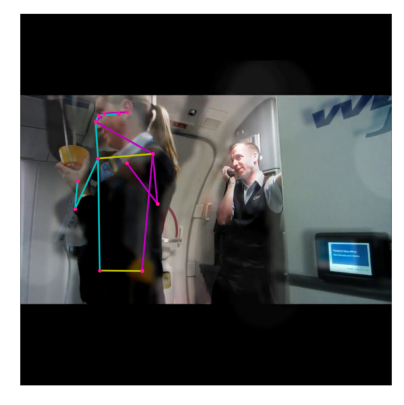

In [10]:
plt.figure(figsize=(5, 5))
plt.imshow(output_overlay)
_ = plt.axis('off')
plt.show()  # Show the visualization for each image


# Function to calculate ratios and distances

In [5]:

def calculate_distance(keypoint1, keypoint2):
    """Calculate the Euclidean distance between two keypoints."""
    return np.linalg.norm(keypoint1 - keypoint2)

def calculate_ratio(distance1, distance2):
    """Calculate the ratio between two distances."""
    return distance1 / distance2

def calculate_angle(keypoint1, keypoint2, keypoint3):
    """Calculate the angle between three keypoints."""
    vector1 = keypoint1 - keypoint2
    vector2 = keypoint3 - keypoint2
    cosine_angle = np.dot(vector1, vector2) / (np.linalg.norm(vector1) * np.linalg.norm(vector2))
    angle_radians = np.arccos(np.clip(cosine_angle, -1.0, 1.0))
    return np.degrees(angle_radians)



# Calculating Physical features using the extracted keyponts 

In [6]:
shoulder_widths=[]
hip_widths=[]
waist_sizes=[]
bust_sizes=[]
hip_sizes=[]
waist_to_hip_ratios=[]
bust_to_waist_ratios=[]
angle_left_arm_torsos=[]

def estimate_physical_attributes(keypoints_with_scores):
    """Estimate physical attributes using keypoints with scores."""
    # Assuming the order of keypoints: [nose, left_eye, right_eye, left_ear, right_ear, 
    #                                    left_shoulder, right_shoulder, left_elbow, right_elbow, 
    #                                    left_wrist, right_wrist, left_hip, right_hip, 
    #                                    left_knee, right_knee, left_ankle, right_ankle]
    
    # Extract keypoints from the array
    for keypoints in keypoints_with_scores:  # Assuming there's only one batch
       # print('I am donoing keypoints ',keypoints)
        # Assuming the order of keypoints in the array matches the order above
        left_shoulder = keypoints[0][0][5]
        right_shoulder = keypoints[0][0][6]
        left_hip = keypoints[0][0][11]
        right_hip = keypoints[0][0][12]
        
        # Calculate distances between keypoints
        shoulder_width = right_shoulder[0] - left_shoulder[0]
        shoulder_widths.append(shoulder_width)
        hip_width = right_hip[0] - left_hip[0]
        hip_widths.append(shoulder_width)
        waist_width = 0.8 * hip_width  # Assuming waist is 75% of hip width
        bust_width = 0.95 * hip_width  # Assuming bust is 95% of hip width
        #bust_sizes.append(bust_width)
        #print(waist_width)
        # Calculate ratios
        waist_to_hip_ratio = waist_width / hip_width
        waist_to_hip_ratios.append(waist_to_hip_ratio)
       # print(bust_width)
        bust_to_waist_ratio = bust_width / waist_width
        #print(bust_to_waist_ratio)
        bust_to_waist_ratios.append(bust_to_waist_ratio)

        # Calculate angle between left arm and torso
        angle_left_arm_torso = calculate_angle(left_shoulder, keypoints[0][0][7], left_hip)
        angle_left_arm_torsos.append(angle_left_arm_torso)
        # Estimate physical attributes
        waist_size = waist_width  # Using the estimated waist width as the waist size
        waist_sizes.append(waist_size)
        bust_size = bust_width  # Using the estimated bust width as the bust size
        bust_sizes.append(bust_size)
        hip_size = hip_width  # Using the calculated hip width as the hip size
        hip_sizes.append(hip_size)

    return shoulder_widths, hip_widths, waist_sizes, bust_sizes, hip_sizes, waist_to_hip_ratios, bust_to_waist_ratios, angle_left_arm_torsos

# Sample keypoints with scores
#keypoints_with_scores = keypoints_with_scores
# Estimate physical attributes
#shoulder_width, hip_width, waist_size, bust_size, hip_size, waist_to_hip_ratio, bust_to_waist_ratio, angle_left_arm_torso = estimate_physical_attributes(keypoints_with_scores)

'''print("Shoulder Widths:", shoulder_width)
print("Hip Widths:", hip_width)
print("Waist Sizes:", waist_size)
print("Bust Sizes:", bust_size)
print("Hip Sizes:", hip_size)
print("Waist-to-Hip Ratios:", waist_to_hip_ratio)
print("Bust-to-Waist Ratios:", bust_to_waist_ratio)
print("Angle between Left Arm and Torsos:", angle_left_arm_torso)
'''

'print("Shoulder Widths:", shoulder_width)\nprint("Hip Widths:", hip_width)\nprint("Waist Sizes:", waist_size)\nprint("Bust Sizes:", bust_size)\nprint("Hip Sizes:", hip_size)\nprint("Waist-to-Hip Ratios:", waist_to_hip_ratio)\nprint("Bust-to-Waist Ratios:", bust_to_waist_ratio)\nprint("Angle between Left Arm and Torsos:", angle_left_arm_torso)\n'

**c09dd740b164b38968ba34d2ae7ce3f7f121c47957432657072c94d2**

# Calculating Facial features using the extracted keyponts 

In [7]:
facial_symmetry_scores=[]
forehead_sizes=[]
def calculate_symmetry_score(left_keypoints, right_keypoints):
    """Calculate facial symmetry score based on the distances between corresponding left and right keypoints."""
    symmetry_scores = []
    for left, right in zip(left_keypoints, right_keypoints):
        distance_left = calculate_distance(left, right)
        symmetry_scores.append(distance_left)
    return np.mean(symmetry_scores)

def estimate_forehead_size(eye_keypoints):
    """Estimate forehead size based on the vertical distance between the eyes."""
    eye_distance = calculate_distance(eye_keypoints[0], eye_keypoints[1])
    return eye_distance * 0.5  # Assuming the forehead size is half the distance between the eyes

# Sample keypoints for facial features (replace with actual keypoints from your model)
'''for keys in keypoints_with_scores:
    left_eye_keypoint = keys[0][0][1]  # Left eye keypoints
    
    right_eye_keypoint = keys[0][0][2]  # Right eye keypoints
    forehead_size = estimate_forehead_size([left_eye_keypoint, right_eye_keypoint])
    facial_symmetry_score = calculate_symmetry_score(left_eye_keypoint, right_eye_keypoint)
    forehead_sizes.append(forehead_size)
    facial_symmetry_scores.append(facial_symmetry_score)'''

# Calculate facial symmetry score


# Estimate forehead size


'''print("Facial Symmetry Score:", facial_symmetry_scores)
print("Estimated Forehead Size:", forehead_sizes)
'''

'print("Facial Symmetry Score:", facial_symmetry_scores)\nprint("Estimated Forehead Size:", forehead_sizes)\n'

# Text generator from extracted featuers 

In [13]:
!pip install textrazor
import textrazor

In [16]:
import textrazor

def generate_textual_descriptions(input_data):
    # Initialize TextRazor API
    textrazor.api_key = "c09dd740b164b38968ba34d2ae7ce3f7f121c47957432657072c94d2"
    client = textrazor.TextRazor(extractors=["entities", "topics"])

    # Mapping of relevant entities to their corresponding features
    relevant_entities = {
        "Hip": "Hip",
        "Waist": "Waist",
        "Shoulder": "Shoulder",
        "Facial symmetry": "Facial Symmetry",
        "Estimated Forehead Size": "Estimated Forehead Size"
    }
    generated_texts = []

    # Generate textual descriptions for each feature
    for feature, values in input_data.items():
        # Initialize textual description for the feature
        generated_text = f"The {feature} sizes are:\n"

        # Iterate over each value for the feature
        for i, value in enumerate(values):
            # Add value description to the generated text
            generated_text += f"- Individual {i+1}: {value}\n"

            # Analyze value description using TextRazor
            response = client.analyze(str(value))

            # Generate textual description for the value
            for entity in response.entities():
                if entity.id in relevant_entities:
                    generated_text += f"    The {relevant_entities[entity.id]} size for individual {i+1} is {entity.relevance_score}.\n"

        generated_texts.append(generated_text)

        # Print generated textual description for the feature
        print(f"Generated Textual Description for {feature}:")
        print(generated_text)

    return generated_texts

# Example input data (replace with your actual data)
input_data = {
    "Shoulder Widths": shoulder_width,
    "Hip Widths": hip_width,
    "Waist Sizes": waist_size,
    "Bust Sizes": bust_size,
    "Hip Sizes": hip_size,
    "Waist-to-Hip Ratios": waist_to_hip_ratio,
    "Bust-to-Waist Ratios": bust_to_waist_ratio,
    "Angle between Left Arm and Torsos": angle_left_arm_torso,
    "Facial Symmetry Score": facial_symmetry_scores,
    "Estimated Forehead Size": forehead_sizes
}

# Generate textual descriptions using the function
generated_texts = generate_textual_descriptions(input_data)


Generated Textual Description for Shoulder Widths:
The Shoulder Widths sizes are:
- Individual 1: 0.011850327253341675
- Individual 2: 0.006000518798828125
- Individual 3: 0.00845634937286377
- Individual 4: 0.004043310880661011
- Individual 5: -0.024017155170440674
- Individual 6: 0.0024461448192596436
- Individual 7: 0.010867297649383545
- Individual 8: -0.021112799644470215
- Individual 9: -0.0012947320938110352
- Individual 10: 0.012406796216964722

Generated Textual Description for Hip Widths:
The Hip Widths sizes are:
- Individual 1: 0.011850327253341675
- Individual 2: 0.006000518798828125
- Individual 3: 0.00845634937286377
- Individual 4: 0.004043310880661011
- Individual 5: -0.024017155170440674
- Individual 6: 0.0024461448192596436
- Individual 7: 0.010867297649383545
- Individual 8: -0.021112799644470215
- Individual 9: -0.0012947320938110352
- Individual 10: 0.012406796216964722

Generated Textual Description for Waist Sizes:
The Waist Sizes sizes are:
- Individual 1: 0.01

# Converting the generated text into vectors for model training 

In [17]:
import gensim.downloader as api

# Load pre-trained Word2Vec model
w2v_model = api.load("word2vec-google-news-300")

[=====---------------------------------------------] 10.3% 171.7/1662.8MB downloaded

In [18]:
def convert_to_text_vectors(generated_texts, w2v_model):
    # Convert generated text lines to numerical vectors
    text_vectors = []
    for line in generated_texts:
        tokens = line.lower().split()  # Tokenize line and convert to lowercase
        # Convert tokens to numerical vectors using Word2Vec model
        vectors = [w2v_model.get_vector(word) for word in tokens if word in w2v_model.key_to_index]
        text_vectors.append(vectors)
    
    return text_vectors

# Example usage:
text_vectors = convert_to_text_vectors(generated_texts, w2v_model)
text_vectors

[[array([ 0.08007812,  0.10498047,  0.04980469,  0.0534668 , -0.06738281,
         -0.12060547,  0.03515625, -0.11865234,  0.04394531,  0.03015137,
         -0.05688477, -0.07617188,  0.01287842,  0.04980469, -0.08496094,
         -0.06347656,  0.00628662, -0.04321289,  0.02026367,  0.01330566,
         -0.01953125,  0.09277344, -0.171875  , -0.00131989,  0.06542969,
          0.05834961, -0.08251953,  0.0859375 , -0.00318909,  0.05859375,
         -0.03491211, -0.0123291 , -0.0480957 , -0.00302124,  0.05639648,
          0.01495361, -0.07226562, -0.05224609,  0.09667969,  0.04296875,
         -0.03540039, -0.07324219,  0.03271484, -0.06176758,  0.00787354,
          0.0035553 , -0.00878906,  0.0390625 ,  0.03833008,  0.04443359,
          0.06982422,  0.01263428, -0.00445557, -0.03320312, -0.04272461,
          0.09765625, -0.02160645, -0.0378418 ,  0.01190186, -0.01391602,
         -0.11328125,  0.09326172, -0.03930664, -0.11621094,  0.02331543,
         -0.01599121,  0.02636719,  0.

In [ ]:
#generated_lines = generated_text.strip().split("\n")


# Creating dataframe for extarcted features 

In [19]:

# Define the extracted features
extracted_features = {

"Shoulder Widths": shoulder_width,
"Hip Widths": hip_width ,
"Waist Sizes": waist_size ,
"Bust Sizes": bust_size,
"Hip Sizes": hip_size ,
"Waist-to-Hip Ratios":waist_to_hip_ratio ,
"Bust-to-Waist Ratios":bust_to_waist_ratio ,
"Angle between Left Arm and Torsos":angle_left_arm_torso ,
"Facial Symmetry Score": facial_symmetry_scores ,
"Estimated Forehead Size": forehead_sizes
    

}

# Convert the extracted features dictionary to a DataFrame
features_df = pd.DataFrame.from_dict(extracted_features)

# Display the DataFrame
print("Extracted Features DataFrame:")
features_df.head(10)


Extracted Features DataFrame:


,Shoulder Widths,Hip Widths,Waist Sizes,Bust Sizes,Hip Sizes,Waist-to-Hip Ratios,Bust-to-Waist Ratios,Angle between Left Arm and Torsos,Facial Symmetry Score,Estimated Forehead Size
0,0.011850,0.011850,0.012071,0.014334,0.015088,0.8,1.1875,73.356383,0.010200,0.012202
1,0.006001,0.006001,-0.007074,-0.008400,-0.008842,0.8,1.1875,126.791580,0.048360,0.063088
2,0.008456,0.008456,0.001284,0.001525,0.001605,0.8,1.1875,52.235834,0.008522,0.008803
3,0.004043,0.004043,-0.009856,-0.011704,-0.012320,0.8,1.1875,60.359161,0.008165,0.009867
4,-0.024017,-0.024017,-0.014073,-0.016711,-0.017591,0.8,1.1875,83.095376,0.023608,0.031320
5,0.002446,0.002446,-0.001044,-0.001240,-0.001305,0.8,1.1875,58.086520,0.005811,0.007990
6,0.010867,0.010867,0.002913,0.003459,0.003641,0.8,1.1875,100.499437,0.074964,0.098959
7,-0.021113,-0.021113,-0.006793,-0.008066,-0.008491,0.8,1.1875,69.875254,0.016511,0.016209
8,-0.001295,-0.001295,-0.004554,-0.005407,-0.005692,0.8,1.1875,137.088806,0.061255,0.079040
9,0.012407,0.012407,-0.000878,-0.001042,-0.001097,0.8,1.1875,41.846296,0.087681,0.121279


# Converting the text vectors dataframe 

In [20]:

# Convert the list of numerical vectors into a DataFrame
text_vectors_df = pd.DataFrame(text_vectors)




In [21]:
text_vectors_df.columns = text_vectors_df.columns.astype(str)

# Preprocessing the dataframes  **Dropping unneccessary columns**

In [22]:
text_vectors_df = text_vectors_df.drop(columns=['13'])


# Expanding the vector columns (**Flattening**)

In [23]:
flattened_text_vectors_df = pd.DataFrame()

for col in text_vectors_df.columns:
    # Convert each element in the Series to a DataFrame
    col_df = pd.DataFrame(text_vectors_df[col].values.tolist())
    
    # Rename the columns of the new DataFrame    
    # Concatenate the new DataFrame with the existing flattened_text_vectors_df along the columns axis
    flattened_text_vectors_df = pd.concat([flattened_text_vectors_df, col_df], axis=1)

# Display the flattened DataFrame
flattened_text_vectors_df.head(10)



,0,1,2,3,4,5,6,7,8,9,...,293,294,295,296,297,298,299,0,0,0
0,0.080078,0.10498,0.049805,0.053467,-0.067383,-0.120605,0.035156,-0.118652,0.043945,0.030151,...,-0.109863,-0.216797,0.12793,0.134766,0.033691,0.014343,-0.011414,None,None,None
1,0.080078,0.10498,0.049805,0.053467,-0.067383,-0.120605,0.035156,-0.118652,0.043945,0.030151,...,-0.109863,-0.216797,0.12793,0.134766,0.033691,0.014343,-0.011414,None,None,None
2,0.080078,0.10498,0.049805,0.053467,-0.067383,-0.120605,0.035156,-0.118652,0.043945,0.030151,...,-0.109863,-0.216797,0.12793,0.134766,0.033691,0.014343,-0.011414,None,None,None
3,0.080078,0.10498,0.049805,0.053467,-0.067383,-0.120605,0.035156,-0.118652,0.043945,0.030151,...,-0.109863,-0.216797,0.12793,0.134766,0.033691,0.014343,-0.011414,None,None,None
4,0.080078,0.10498,0.049805,0.053467,-0.067383,-0.120605,0.035156,-0.118652,0.043945,0.030151,...,-0.109863,-0.216797,0.12793,0.134766,0.033691,0.014343,-0.011414,None,None,None
5,0.080078,0.10498,0.049805,0.053467,-0.067383,-0.120605,0.035156,-0.118652,0.043945,0.030151,...,-0.109863,-0.216797,0.12793,0.134766,0.033691,0.014343,-0.011414,None,None,None
6,0.080078,0.10498,0.049805,0.053467,-0.067383,-0.120605,0.035156,-0.118652,0.043945,0.030151,...,-0.109863,-0.216797,0.12793,0.134766,0.033691,0.014343,-0.011414,None,None,None
7,0.080078,0.10498,0.049805,0.053467,-0.067383,-0.120605,0.035156,-0.118652,0.043945,0.030151,...,-0.109863,-0.216797,0.12793,0.134766,0.033691,0.014343,-0.011414,"[0.10449219, -0.079589844, -0.0054626465, 0.23...","[0.10449219, -0.079589844, -0.0054626465, 0.23...","[0.10449219, -0.079589844, -0.0054626465, 0.23..."
8,0.080078,0.10498,0.049805,0.053467,-0.067383,-0.120605,0.035156,-0.118652,0.043945,0.030151,...,-0.109863,-0.216797,0.12793,0.134766,0.033691,0.014343,-0.011414,"[0.10449219, -0.079589844, -0.0054626465, 0.23...",None,None
9,0.080078,0.10498,0.049805,0.053467,-0.067383,-0.120605,0.035156,-0.118652,0.043945,0.030151,...,-0.109863,-0.216797,0.12793,0.134766,0.033691,0.014343,-0.011414,"[0.10449219, -0.079589844, -0.0054626465, 0.23...",None,None


# Renaming the newly created columns 

In [24]:
# Generate unique column names
unique_column_names = [f"col_{i}" for i in range(len(flattened_text_vectors_df.columns))]

# Assign unique names to the columns
flattened_text_vectors_df.columns = unique_column_names


# removing some columns which contain vectors which are redundant (col_3902,col_3901,col_3900)

In [27]:
# Identify rows containing numpy arrays
rows_with_arrays = flattened_text_vectors_df['col_3902'].apply(lambda x: isinstance(x, np.ndarray))

# Drop the column if it contains arrays
if any(rows_with_arrays):
    flattened_text_vectors_df.drop('col_3902', axis=1, inplace=True)




# Merge the text vecotors and the extracted features for creating a model

In [28]:
merged_df = pd.concat([features_df, flattened_text_vectors_df], axis=1)

merged_df.head(100)

,Shoulder Widths,Hip Widths,Waist Sizes,Bust Sizes,Hip Sizes,Waist-to-Hip Ratios,Bust-to-Waist Ratios,Angle between Left Arm and Torsos,Facial Symmetry Score,Estimated Forehead Size,...,col_3890,col_3891,col_3892,col_3893,col_3894,col_3895,col_3896,col_3897,col_3898,col_3899
0,0.011850,0.011850,0.012071,0.014334,0.015088,0.8,1.1875,73.356383,0.010200,0.012202,...,0.07666,0.105957,0.036133,-0.109863,-0.216797,0.12793,0.134766,0.033691,0.014343,-0.011414
1,0.006001,0.006001,-0.007074,-0.008400,-0.008842,0.8,1.1875,126.791580,0.048360,0.063088,...,0.07666,0.105957,0.036133,-0.109863,-0.216797,0.12793,0.134766,0.033691,0.014343,-0.011414
2,0.008456,0.008456,0.001284,0.001525,0.001605,0.8,1.1875,52.235834,0.008522,0.008803,...,0.07666,0.105957,0.036133,-0.109863,-0.216797,0.12793,0.134766,0.033691,0.014343,-0.011414
3,0.004043,0.004043,-0.009856,-0.011704,-0.012320,0.8,1.1875,60.359161,0.008165,0.009867,...,0.07666,0.105957,0.036133,-0.109863,-0.216797,0.12793,0.134766,0.033691,0.014343,-0.011414
4,-0.024017,-0.024017,-0.014073,-0.016711,-0.017591,0.8,1.1875,83.095376,0.023608,0.031320,...,0.07666,0.105957,0.036133,-0.109863,-0.216797,0.12793,0.134766,0.033691,0.014343,-0.011414
5,0.002446,0.002446,-0.001044,-0.001240,-0.001305,0.8,1.1875,58.086520,0.005811,0.007990,...,0.07666,0.105957,0.036133,-0.109863,-0.216797,0.12793,0.134766,0.033691,0.014343,-0.011414
6,0.010867,0.010867,0.002913,0.003459,0.003641,0.8,1.1875,100.499437,0.074964,0.098959,...,0.07666,0.105957,0.036133,-0.109863,-0.216797,0.12793,0.134766,0.033691,0.014343,-0.011414
7,-0.021113,-0.021113,-0.006793,-0.008066,-0.008491,0.8,1.1875,69.875254,0.016511,0.016209,...,0.07666,0.105957,0.036133,-0.109863,-0.216797,0.12793,0.134766,0.033691,0.014343,-0.011414
8,-0.001295,-0.001295,-0.004554,-0.005407,-0.005692,0.8,1.1875,137.088806,0.061255,0.079040,...,0.07666,0.105957,0.036133,-0.109863,-0.216797,0.12793,0.134766,0.033691,0.014343,-0.011414
9,0.012407,0.012407,-0.000878,-0.001042,-0.001097,0.8,1.1875,41.846296,0.087681,0.121279,...,0.07666,0.105957,0.036133,-0.109863,-0.216797,0.12793,0.134766,0.033691,0.014343,-0.011414


# Generate synthetic labels for perceived intelligence, cooperativeness, and celibacy scores


In [8]:

# Define the number of individuals in the dataset
num_individuals = 10  # Replace with the actual number of individuals in your dataset

# Generate synthetic labels for perceived intelligence, cooperativeness, and celibacy scores
np.random.seed(26)  # Set seed for reproducibility
intelligence_scores = np.random.randint(1, 11, size=num_individuals)
cooperativeness_scores = np.random.randint(1, 11, size=num_individuals)
celibacy_scores = np.random.randint(1, 11, size=num_individuals)

# Print the first few synthetic labels for verification
print("Synthetic Intelligence Scores:", intelligence_scores[:10])
print("Synthetic Cooperativeness Scores:", cooperativeness_scores[:10])
print("Synthetic Celibacy Scores:", celibacy_scores[:10])


Synthetic Intelligence Scores: [6 7 1 2 7 4 1 5 3 2]
Synthetic Cooperativeness Scores: [ 8  4  6 10  5  9  6  8  7  9]
Synthetic Celibacy Scores: [3 6 1 3 4 4 4 4 2 2]


# Convert to dataframe 

In [9]:
import pandas as pd

# Create a DataFrame to store the synthetic labels
labels_df = pd.DataFrame({
    'Intelligence': intelligence_scores,
    'Cooperativeness': cooperativeness_scores,
    'Celibacy': celibacy_scores
})

# Print the first few rows of the DataFrame to verify the structure
print(labels_df.head())


   Intelligence  Cooperativeness  Celibacy
0             6                8         3
1             7                4         6
2             1                6         1
3             2               10         3
4             7                5         4


In [ ]:
# Convert column names to strings
merged_df.columns = merged_df.columns.astype(str)


# Split the data into training and testing sets (80% training, 20% testing)


In [34]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(merged_df, labels_df, test_size=0.2, random_state=42)

print("Training set size:", len(X_train))
print("Testing set size:", len(X_test))


Training set size: 8
Testing set size: 2


In [35]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error


# Initialize the Random Forest model
rf_model = RandomForestRegressor(random_state=42)

# Train the Random Forest model
rf_model.fit(X_train, y_train)

# Make predictions on the testing data
y_pred = rf_model.predict(X_test)

# Evaluate the model using mean squared error
mse = mean_squared_error(y_test, y_pred)
print("Mean Squared Error:", mse)


Mean Squared Error: 3.4231166666666666


# **For Testing the model**

In [ ]:

# Make predictions on the testing data
predicted_scores = rf_model.predict(X_test)

# Output predictions for each individual
for i, predicted_score in enumerate(predicted_scores):
    print(f"Predicted Scores for Individual {i+1}:")
    print("Intelligence:", predicted_score['Intelligence'])
    print("Cooperativeness:", predicted_score['Cooperativeness'])
    print("Celibacy:", predicted_score['Celibacy'])
    print()


# **Testing** 

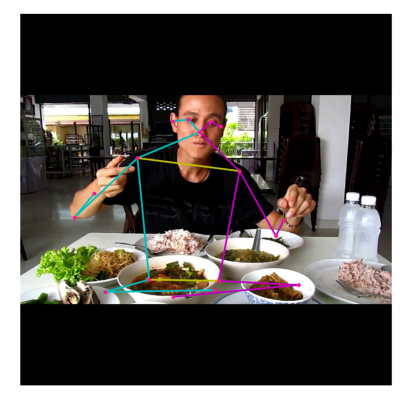

In [15]:
tests_keypoints_with_scores=[]
# Load the input image.
test_image_path = '/kaggle/input/mpii-human-pose/mpii_human_pose_v1/images/000099186.jpg'
image = tf.io.read_file(test_image_path)
image = tf.image.decode_jpeg(image)
# Resize and pad the image to keep the aspect ratio and fit the expected size.
input_image = tf.expand_dims(image, axis=0)
input_image = tf.image.resize_with_pad(input_image, input_size, input_size)

# Run model inference.
test_keypoints_with_scores = movenet(input_image)
tests_keypoints_with_scores.append(test_keypoints_with_scores)

# Visualize the predictions with image.
display_image = tf.expand_dims(image, axis=0)
display_image = tf.cast(tf.image.resize_with_pad(
    display_image, 1280, 1280), dtype=tf.int32)
output_overlay = draw_prediction_on_image(
    np.squeeze(display_image.numpy(), axis=0), test_keypoints_with_scores)

plt.figure(figsize=(5, 5))
plt.imshow(output_overlay)
_ = plt.axis('off')

In [ ]:
test_left_eye_keypoint = tests_keypoints_with_scores[0][0][0][1]  # Left eye keypoints
test_right_eye_keypoint = tests_keypoints_with_scores[0][0][0][2]  # Right eye keypoints
    
test_shoulder_width, test_hip_width, test_waist_size, test_bust_size, test_hip_size, test_waist_to_hip_ratio, test_bust_to_waist_ratio, test_angle_left_arm_torso = estimate_physical_attributes(tests_keypoints_with_scores)
test_forehead_size = estimate_forehead_size([test_left_eye_keypoint, test_right_eye_keypoint])
test_facial_symmetry_score = calculate_symmetry_score(test_left_eye_keypoint, test_right_eye_keypoint)

#test_generated_texts = generate_textual_descriptions(test_input_data)


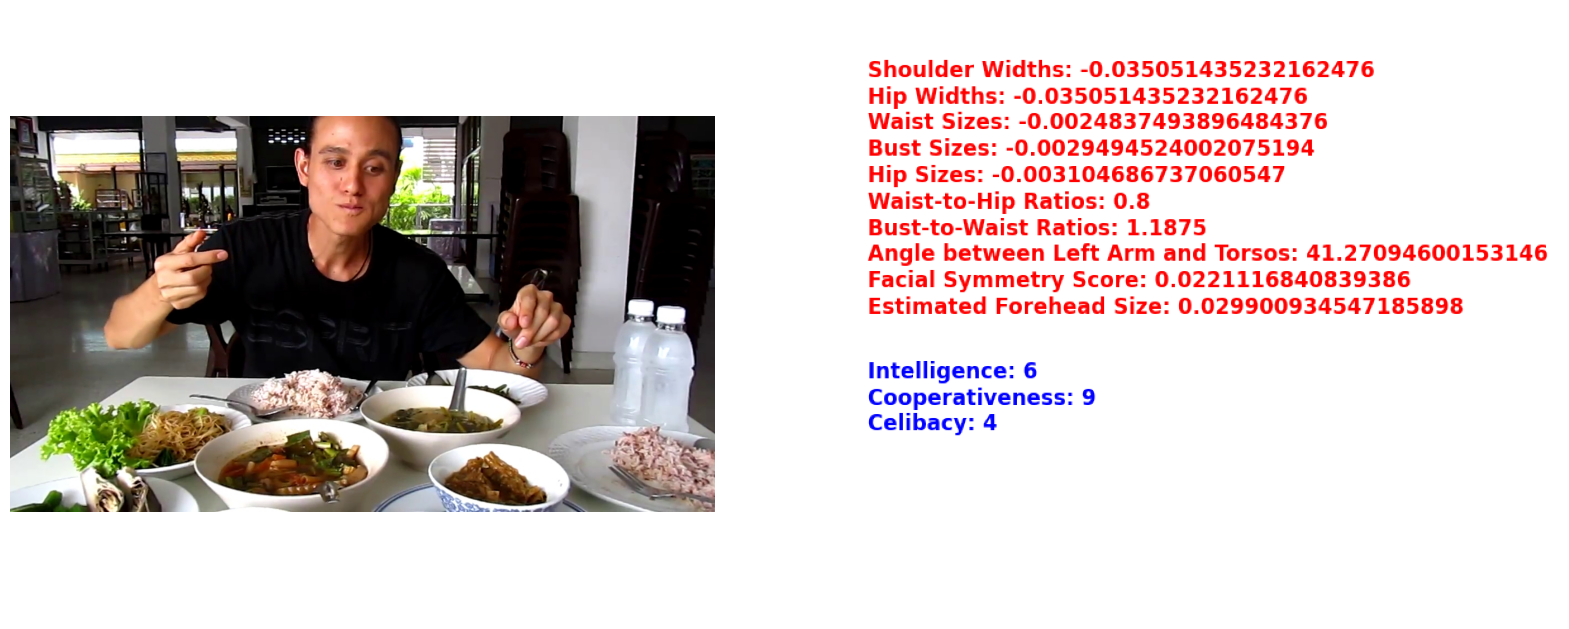

In [13]:
import matplotlib.pyplot as plt

# Load the image
image = plt.imread('/kaggle/input/mpii-human-pose/mpii_human_pose_v1/images/000099186.jpg')

# Define extracted features
extracted_features = {
    "Shoulder Widths": test_shoulder_width[0],
    "Hip Widths": test_hip_width[0],
    "Waist Sizes": test_waist_size[0],
    "Bust Sizes": test_bust_size[0],
    "Hip Sizes": test_hip_size[0],
    "Waist-to-Hip Ratios": test_waist_to_hip_ratio[0],
    "Bust-to-Waist Ratios": test_bust_to_waist_ratio[0],
    "Angle between Left Arm and Torsos": test_angle_left_arm_torso[0],
    "Facial Symmetry Score": test_facial_symmetry_score,
    "Estimated Forehead Size": test_forehead_size
}

# Format and prepare extracted features text
feature_text = '\n'.join([f"{key}: {value}" for key, value in extracted_features.items()])

# Define predicted outputs
predicted_outputs = {
    'Intelligence': intelligence_scores[0],
    'Cooperativeness': cooperativeness_scores[5],
    'Celibacy': celibacy_scores[6]
}

# Format and prepare predicted outputs text
output_text = '\n'.join([f"{key}: {value}" for key, value in predicted_outputs.items()])

# Create a separate plot for the text
plt.figure(figsize=(6, 6))  # Set the figure size for text
plt.text(0, 0.5, feature_text, fontsize=12, family='sans-serif', weight='bold',color='red')  # Adjust the text position, size, font family, and weight as needed
plt.text(0, 0.3, output_text, fontsize=12, family='sans-serif', weight='bold',color='blue')  # Adjust the text position, size, font family, and weight as needed
plt.axis('off')  # Turn off axis ticks and labels
plt.savefig('text.png', bbox_inches='tight', transparent=True)  # Save the text plot to an image with transparency
plt.close()

# Load the saved text image
text_image = plt.imread('text.png')

# Display the text image alongside the original image
fig, axes = plt.subplots(1, 2, figsize=(20, 20))  # Create a subplot with 1 row and 2 columns
axes[0].imshow(image)  # Display the original image
axes[0].axis('off')  # Turn off axis ticks and labels
axes[1].imshow(text_image)  # Display the text image
axes[1].axis('off')  # Turn off axis ticks and labels
plt.show()


In [43]:

# Make predictions on the testing data
y_pred = rf_model.predict(X_test)

# Evaluate the model for each trait using mean squared error
mse_intelligence = mean_squared_error(intelligence_scores[:2], y_pred[:, 0])
mse_cooperativeness = mean_squared_error(cooperativeness_scores[:2], y_pred[:, 1])
mse_celibacy = mean_squared_error(celibacy_scores[:2], y_pred[:, 2])

print("Mean Squared Error - Intelligence:", mse_intelligence)
print("Mean Squared Error - Cooperativeness:", mse_cooperativeness)
print("Mean Squared Error - Celibacy:", mse_celibacy)



Mean Squared Error - Intelligence: 3.7538
Mean Squared Error - Cooperativeness: 3.663050000000001
Mean Squared Error - Celibacy: 3.5424999999999995
